In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import cv2
from PIL import Image
from skimage import data, exposure
from skimage.feature import hog,local_binary_pattern
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.datasets import fetch_lfw_pairs
lfw_pairs = fetch_lfw_pairs()

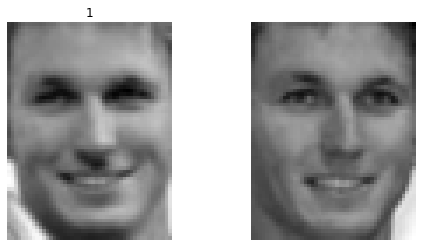

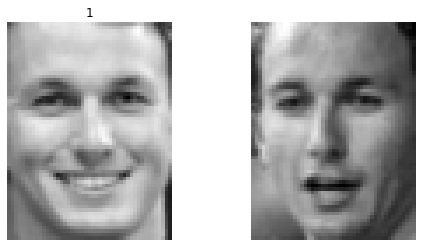

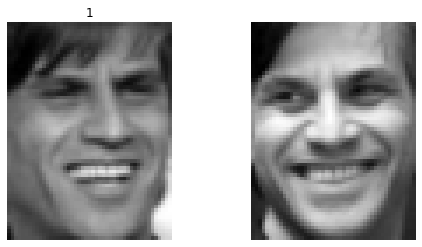

In [4]:
for i in range (0,3):
  image = lfw_pairs.pairs[i]
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

  ax1.axis('off')
  ax1.imshow(image[0], cmap=plt.cm.gray)
  ax1.set_title(lfw_pairs.target[i])

  ax2.axis('off')
  ax2.imshow(image[1], cmap=plt.cm.gray)
  
  plt.show()
  

In [6]:
def get_HOG(image, n=2, plot= False):

  fd, hog_image = hog(image, orientations=2, pixels_per_cell=(n,n),
                      cells_per_block=(n, n), visualize=True)
  
  if plot:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
    ax1.axis('off')
    ax1.imshow(image, cmap=plt.cm.gray)
    ax2.axis('off')
    ax2.imshow(hog_image, cmap=plt.cm.gray)
    ax1.set_title('pixels_per_cell:({},{})'.format(n,n))
  
  # fd, hog_image = hog(image, orientations=2, pixels_per_cell=(4,4),
  #                     cells_per_block=(4, 4), visualize=True)
  
  return fd, hog_image

def pooling(image, n, stride):

    image_h, image_w = image.shape

    output_h = (image_h - n) // stride + 1
    output_w = (image_w - n) // stride + 1

    new_image = np.zeros((output_h, output_w)).astype(np.float32)

    for y in range(0, output_h):
        for x in range(0, output_w):
            new_image[y][x] = np.mean(image[y * stride:y * stride + n, x * stride:x * stride + n]).astype(np.float32)
    return new_image


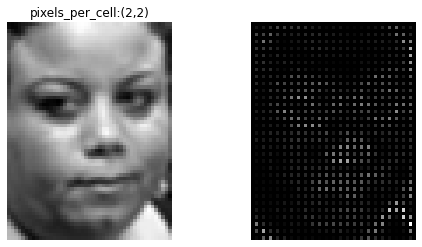

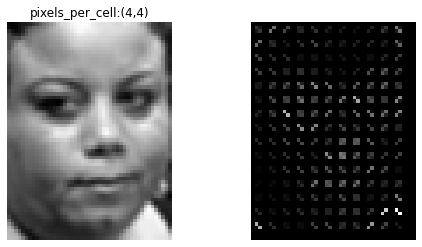

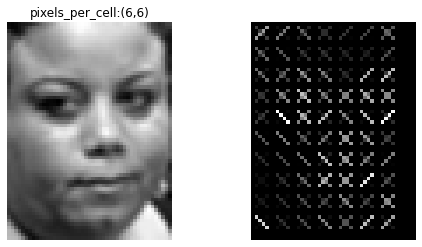

In [40]:
get_HOG(image[0], n=2, plot=True);
get_HOG(image[0], n=4, plot=True);
get_HOG(image[0], n=6, plot=True);

In [31]:
m, n_pairs, widt, height = lfw_pairs.pairs.shape
X_hog = []

for i in range(0,m):
  image = lfw_pairs.pairs[i]
  left_img = image[0]
  right_img = image[1]
  HOG_left,_ = get_HOG(left_img, n= 6)
  HOG_right,_ = get_HOG(right_img, n= 6)
  # HOG_diff_vect = np.r_[HOG_left.flatten(),HOG_right.flatten()]
  HOG_diff_vect = ((HOG_left - HOG_right)**2).flatten()
  X_hog.append(HOG_diff_vect)

In [18]:
m, n_pairs, widt, height = lfw_pairs.pairs.shape
X_pooling = []

for i in range(0,m):
  image = lfw_pairs.pairs[i]
  left_img = image[0]
  right_img = image[1]
  _,HOG_left = get_HOG(left_img, n=6)
  _,HOG_right = get_HOG(right_img,n=6)
  pooling_left= pooling(HOG_left, n=8, stride=1)
  pooling_right= pooling(HOG_right, n=8, stride=1)
  HOG_diff = pooling_left - pooling_right
  HOG_diff_vect = HOG_diff.flatten()
  X_pooling.append(HOG_diff_vect)

In [48]:
import random

z = [3,4,5]
random.shuffle(z)
print(z)

[4, 5, 3]


In [55]:
def get_train_test(X,y):

  X = pd.DataFrame(np.array(X))
  y = pd.DataFrame(y)
  m = X.shape[0]

  print('dimensoes X:',X.shape)
  print('dimensoes y:',y.shape)

  x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

  return x_train, x_test, y_train, y_test

In [10]:
def tune_PCA(x, step=5, max_iter=10):
  iter=0
  explained_var=0
  n_components= 20
  results={}

  while (iter<=max_iter) & (explained_var<0.999):
    iter+=1
    pca = PCA(n_components=n_components)
    pca.fit(x)
    explained_var = pca.explained_variance_ratio_.sum()
    print('componentes:{}/ exp_var_tot:{}'.format(n_components, explained_var))
    results[n_components] = explained_var
    n_components = n_components + step

  return pca, results

# best_pca, results = tune_PCA(x_train)

# soma = 0
# for i in range(0, len(pca.explained_variance_ratio_)):
#   soma += pca.explained_variance_ratio_[i]
#   print(f'PC{ i+1}: {pca.explained_variance_ratio_[i]} - {round(soma*100,2)}%')

In [67]:
y_train.values.reshape(1,-1)

array([[0, 0, 1, ..., 0, 0, 1]])

In [68]:
def test_model(classifier, x_train, x_test, y_train, y_test):
  classifier.fit(x_train, y_train)
  y_pred_train = classifier.predict(x_train)
  y_pred_test = classifier.predict(x_test)
  
  print('######## TREINO ########')
  print('Acuracia:', (y_pred_train==y_train.values.reshape(1,-1)).mean())
  print(classification_report(y_train, y_pred_train))

  print('######## TESTE ########')
  print('Acuracia:', (y_pred_test==y_test.values.reshape(1,-1)).mean())
  print(classification_report(y_test, y_pred_test))
  

In [58]:
x_train, x_test, y_train, y_test = get_train_test(X_hog, lfw_pairs.target)

# best_pca, results = tune_PCA(x_train, step=100, max_iter=10)

dimensoes X: (2200, 720)
dimensoes y: (2200, 1)


In [35]:

print('Normal com HOG:')
test_model(RandomForestClassifier(random_state=42),x_train, x_test, y_train, y_test)
print('\n\n')

print('Normal com HOG + limitando nivel arvores:')
test_model(RandomForestClassifier(max_depth=8,random_state=42),x_train, x_test, y_train, y_test)
print('\n\n')

# print('Normal com HOG + PCA:')
# test_model(RandomForestClassifier(min_samples_leaf=8,random_state=42),best_pca.transform(x_train), best_pca.transform(x_test), y_train, y_test)
# print('\n\n')

Normal com HOG:
######## TREINO ########
Acuracia: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       777
           1       1.00      1.00      1.00       763

    accuracy                           1.00      1540
   macro avg       1.00      1.00      1.00      1540
weighted avg       1.00      1.00      1.00      1540

######## TESTE ########
Acuracia: 0.6454545454545455
              precision    recall  f1-score   support

           0       0.61      0.74      0.67       323
           1       0.69      0.56      0.62       337

    accuracy                           0.65       660
   macro avg       0.65      0.65      0.64       660
weighted avg       0.65      0.65      0.64       660




Normal com HOG + limitando nivel arvores:
######## TREINO ########
Acuracia: 0.9993506493506493
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       777
           1       1.00      1

In [24]:
x_train, x_test, y_train, y_test = get_train_test(X_pooling, lfw_pairs.target)

print('Normal com HOG + pooling:')
test_model(RandomForestClassifier(random_state=42),x_train, x_test, y_train, y_test)
print('\n\n')

dimensoes X: (2200, 2200)
dimensoes y: (2200,)
Normal com HOG + pooling:
######## TREINO ########
Acuracia: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       759
           1       1.00      1.00      1.00       781

    accuracy                           1.00      1540
   macro avg       1.00      1.00      1.00      1540
weighted avg       1.00      1.00      1.00      1540

######## TESTE ########
Acuracia: 0.6136363636363636
              precision    recall  f1-score   support

           0       0.63      0.60      0.62       341
           1       0.60      0.63      0.61       319

    accuracy                           0.61       660
   macro avg       0.61      0.61      0.61       660
weighted avg       0.61      0.61      0.61       660






In [69]:
test_model(RandomForestClassifier(n_estimators= 200, max_depth= 5, min_samples_leaf=8, random_state=42),x_train, x_test, y_train, y_test)

######## TREINO ########
Acuracia: 0.9064935064935065
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       777
           1       0.92      0.89      0.90       763

    accuracy                           0.91      1540
   macro avg       0.91      0.91      0.91      1540
weighted avg       0.91      0.91      0.91      1540

######## TESTE ########
Acuracia: 0.6181818181818182
              precision    recall  f1-score   support

           0       0.60      0.69      0.64       323
           1       0.65      0.55      0.60       337

    accuracy                           0.62       660
   macro avg       0.62      0.62      0.62       660
weighted avg       0.62      0.62      0.62       660



In [70]:
classifier = RandomForestClassifier(random_state=42).fit(x_train, y_train)
y_pred_train = classifier.predict(x_train)
y_pred_test = classifier.predict(x_test)

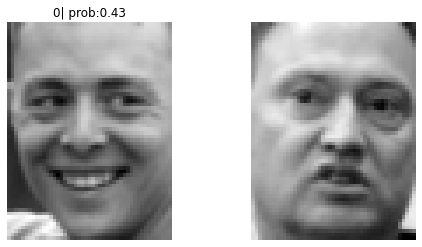

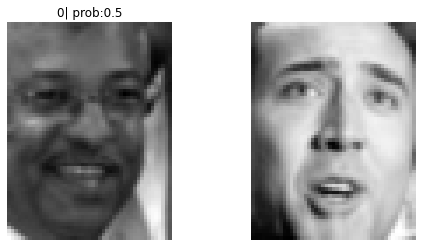

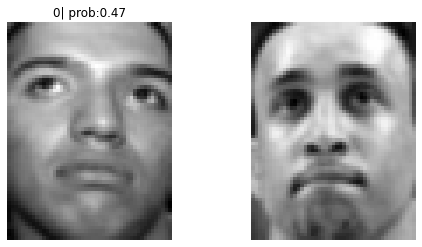

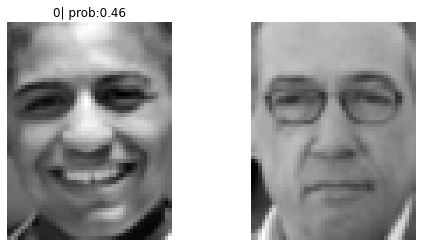

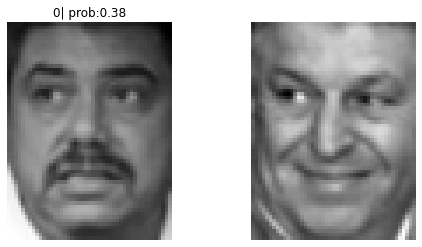

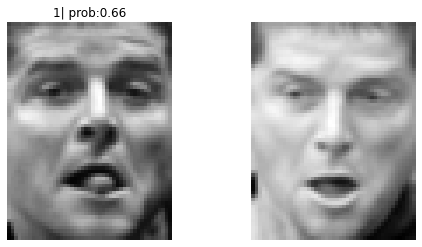

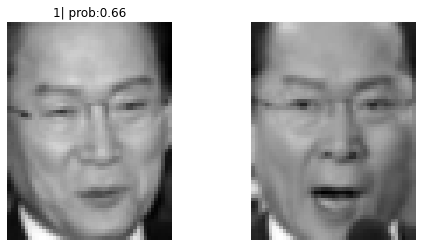

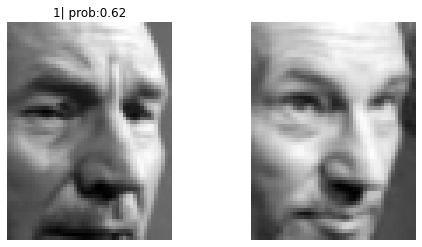

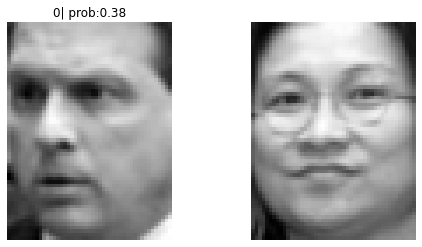

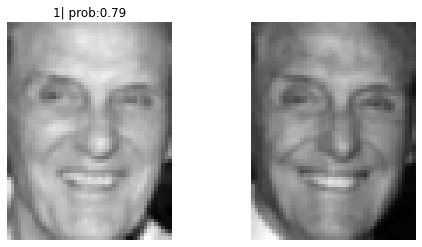

In [96]:
correct = y_test[(y_pred_test==y_test.values.reshape(1,-1))[0]].index

results_test = x_test.copy()
results_test['proba'] = classifier.predict_proba(x_test)[:,1]

for i in range (0,10):
  id = correct[i]
  image = lfw_pairs.pairs[id]
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

  ax1.axis('off')
  ax1.imshow(image[0], cmap=plt.cm.gray)
  ax1.set_title(str(lfw_pairs.target[id]) + '| prob:' + str(results_test['proba'].loc[id]))

  ax2.axis('off')
  ax2.imshow(image[1], cmap=plt.cm.gray)
  
  plt.show()
  

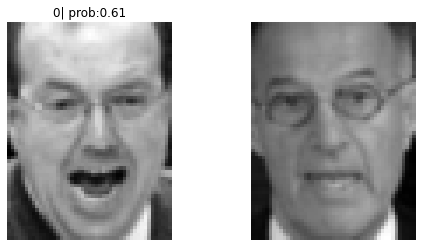

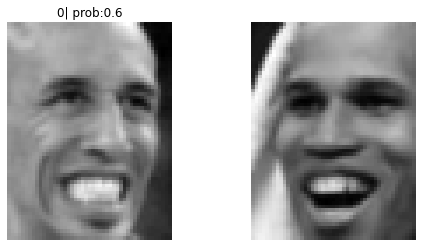

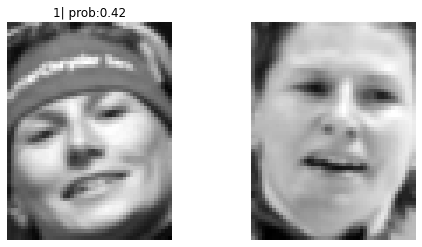

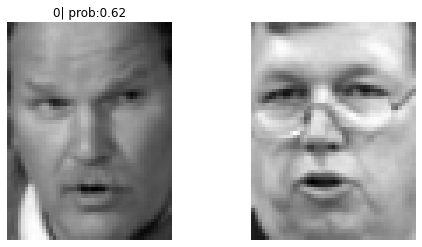

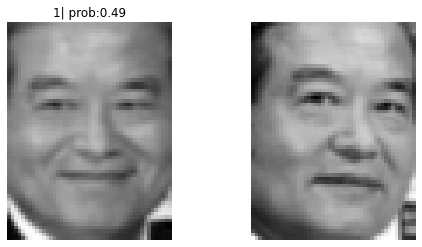

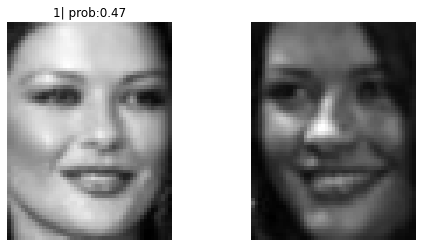

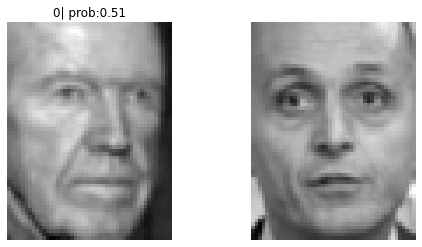

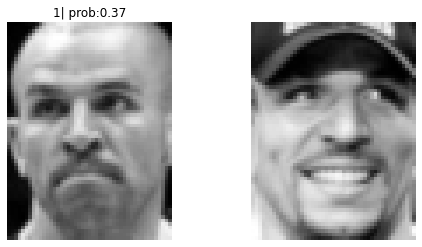

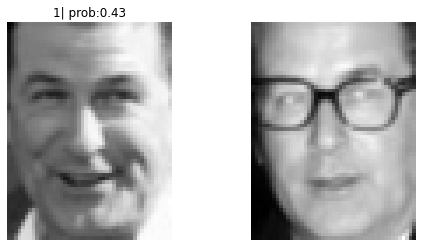

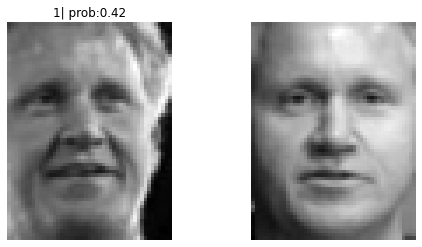

In [97]:
incorrect = y_test[(y_pred_test!=y_test.values.reshape(1,-1))[0]].index

results_test = x_test.copy()
results_test['proba'] = classifier.predict_proba(x_test)[:,1]

for i in range (0,10):
  id = incorrect[i]
  image = lfw_pairs.pairs[id]
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

  ax1.axis('off')
  ax1.imshow(image[0], cmap=plt.cm.gray)
  ax1.set_title(str(lfw_pairs.target[id]) + '| prob:' + str(results_test['proba'].loc[id]))

  ax2.axis('off')
  ax2.imshow(image[1], cmap=plt.cm.gray)
  
  plt.show()
  

In [113]:
from tqdm import tqdm

def featurize_images():

  METHOD = 'uniform'
  radius = 1
  n_points = 4

  m, n_pairs, widt, height = lfw_pairs.pairs.shape
  X_out = []

  for i in tqdm(range(0,m)):
    image = lfw_pairs.pairs[i]
    left_img = image[0]
    right_img = image[1]

    # HOG
    HOG_left,_ = get_HOG(left_img, n= 6)
    HOG_right,_ = get_HOG(right_img, n= 6)

    # LOB
    lbp_left = local_binary_pattern(left_img, n_points, radius, METHOD)
    lbp_right = local_binary_pattern(right_img, n_points, radius, METHOD)

    # HOG_diff_vect = np.r_[HOG_left.flatten(),HOG_right.flatten()]
    HOG_diff_vect = ((HOG_left - HOG_right)**2).flatten()
    lbp_diff_vect = ((lbp_left - lbp_right)**2).flatten()

    diff_vect = np.r_[HOG_diff_vect.flatten(),lbp_diff_vect.flatten()]

    X_out.append(diff_vect)

  return X_out

In [114]:
X_HOG_lbp = featurize_images()

100%|██████████| 2200/2200 [00:17<00:00, 123.04it/s]


In [ ]:
x_train, x_test, y_train, y_test = get_train_test(X_HOG_lbp, lfw_pairs.target)


In [143]:
test_model(RandomForestClassifier(),x_train, x_test, y_train, y_test)

######## TREINO ########
Acuracia: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       777
           1       1.00      1.00      1.00       763

    accuracy                           1.00      1540
   macro avg       1.00      1.00      1.00      1540
weighted avg       1.00      1.00      1.00      1540

######## TESTE ########
Acuracia: 0.6212121212121212
              precision    recall  f1-score   support

           0       0.60      0.67      0.64       323
           1       0.65      0.57      0.61       337

    accuracy                           0.62       660
   macro avg       0.62      0.62      0.62       660
weighted avg       0.62      0.62      0.62       660



In [127]:

test_model(RandomForestClassifier(random_state=42, max_depth=8, min_samples_leaf = 20, n_estimators=500),x_train, x_test, y_train, y_test)

dimensoes X: (2200, 3634)
dimensoes y: (2200, 1)
######## TREINO ########
Acuracia: 0.9616883116883117
              precision    recall  f1-score   support

           0       0.94      0.98      0.96       777
           1       0.98      0.94      0.96       763

    accuracy                           0.96      1540
   macro avg       0.96      0.96      0.96      1540
weighted avg       0.96      0.96      0.96      1540

######## TESTE ########
Acuracia: 0.6166666666666667
              precision    recall  f1-score   support

           0       0.60      0.67      0.63       323
           1       0.64      0.56      0.60       337

    accuracy                           0.62       660
   macro avg       0.62      0.62      0.62       660
weighted avg       0.62      0.62      0.62       660



In [142]:
from sklearn.linear_model import LogisticRegression

test_model(LogisticRegression(random_state=42, penalty='l2', C=1e-5),x_train, x_test, y_train, y_test)

######## TREINO ########
Acuracia: 0.8980519480519481
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       777
           1       0.92      0.88      0.89       763

    accuracy                           0.90      1540
   macro avg       0.90      0.90      0.90      1540
weighted avg       0.90      0.90      0.90      1540

######## TESTE ########
Acuracia: 0.55
              precision    recall  f1-score   support

           0       0.53      0.63      0.58       323
           1       0.57      0.48      0.52       337

    accuracy                           0.55       660
   macro avg       0.55      0.55      0.55       660
weighted avg       0.55      0.55      0.55       660



# PCA

In [ ]:
#Normalização Z-score
scaler = StandardScaler()
scaler.fit(X)
x_scaler = scaler.transform(X)

In [ ]:
pca = PCA(n_components=500, random_state=42)
pca.fit(x_scaler)
X_pca = pca.transform(x_scaler)

In [ ]:
soma = 0
for i in range(0, len(pca.explained_variance_ratio_)):
  soma += pca.explained_variance_ratio_[i]
  print(f'PC{ i+1}: {pca.explained_variance_ratio_[i]} - {round(soma*100,2)}%')

PC1: 0.014659541856818626 - 1.47%
PC2: 0.014485608485313889 - 2.91%
PC3: 0.013919307664872049 - 4.31%
PC4: 0.010772115562762983 - 5.38%
PC5: 0.010023964263980943 - 6.39%
PC6: 0.008329674487603708 - 7.22%
PC7: 0.00750096268560485 - 7.97%
PC8: 0.007204215449515421 - 8.69%
PC9: 0.0064566808325155385 - 9.34%
PC10: 0.006321121100377781 - 9.97%
PC11: 0.005758628784670791 - 10.54%
PC12: 0.005328032808227122 - 11.08%
PC13: 0.005192775074060721 - 11.6%
PC14: 0.004911112467509398 - 12.09%
PC15: 0.004700821233188661 - 12.56%
PC16: 0.004535256137717344 - 13.01%
PC17: 0.004343154831617322 - 13.44%
PC18: 0.004305281592042019 - 13.87%
PC19: 0.004248141481234923 - 14.3%
PC20: 0.004172467241751414 - 14.72%
PC21: 0.003993552223035023 - 15.12%
PC22: 0.003973777040255336 - 15.51%
PC23: 0.003852683733496444 - 15.9%
PC24: 0.0038004474385093007 - 16.28%
PC25: 0.0037118710356445384 - 16.65%
PC26: 0.0036571791741061527 - 17.02%
PC27: 0.0034616070640477183 - 17.36%
PC28: 0.003427298412724712 - 17.7%
PC29: 0.003

In [ ]:
#Normalização Z-score
scaler = StandardScaler()
scaler.fit(X_pca)
X_pca = scaler.transform(X_pca)

# SVM

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X_pca,y,test_size=0.3,random_state=42,stratify=y)

In [ ]:
%%time
param_grid={'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['rbf','poly','sigmoid']} #'linea'
svc=svm.SVC(probability=True)
model=GridSearchCV(svc,param_grid)
model.fit(x_train,y_train)
model.best_params_

CPU times: user 8min 5s, sys: 655 ms, total: 8min 5s
Wall time: 8min 22s


{'C': 0.1, 'gamma': 0.1, 'kernel': 'poly'}

In [ ]:
y_train_pred = model.predict(x_train)
y_test_pred=model.predict(x_test)

print("Acurácia do Treinamento:", accuracy_score(y_train, y_train_pred))
print("Acurácia do Teste:", accuracy_score(y_test, y_test_pred))

Acurácia do Treinamento: 1.0
Acurácia do Teste: 0.6227272727272727


# MLP

In [ ]:
# transformar categorias em one-hot-encoding
target = keras.utils.to_categorical(y, 2)
target[0], target[1200]

(array([0., 1.], dtype=float32), array([1., 0.], dtype=float32))

In [ ]:
def bissecao_rna(dEdA, dEdB, A, B, X, Yd, N):
    
    def h_linha(au, dEdA, dEdB, dv, X, Yd, N):
      An = A - au*dEdA;
      Bn = B - au*dEdB;

      dJdAn, dJdBn = calculo_gradiente(X, Yd, An, Bn, N)
      g=np.array((dJdAn.flatten(),dJdBn.flatten()))
      
      return  (np.sum(dv[0] * g[0]) + np.sum(dv[1] * g[1]))
    
    dv = np.array((-dEdA.flatten(),-dEdB.flatten())) 
    
    au = np.random.rand() # Chute inicial

    al = 0.0
    au = np.random.rand() # Chute inicial
    it = 0

    hl = h_linha(au, dEdA, dEdB, dv, X, Yd, N)

    while hl < 0: #Verifica au está acima de zero.
      al = au
      au = au * 2
      hl = h_linha(au, dEdA, dEdB, dv, X, Yd, N)
      
    a_medio = (al + au) / 2

    hl = h_linha(au, dEdA, dEdB, dv, X, Yd, N)

    itmax = np.int(np.ceil(np.log(au-al) - np.log(1e-5))/np.log(2)) #interações.

    #while (it < itmax) and ((au - al)<=1.0) and (np.abs(hl)>10.0):
    while (it < itmax):
      it += 1
      if hl > 0:
        au = a_medio
      elif hl < 0:
        al = a_medio
      elif hl == 0:
        return a_medio
      
      a_medio = (al + au) / 2
      hl = h_linha(au, dEdA, dEdB, dv, X, Yd, N)

    return a_medio

In [ ]:
def calculo_saida(X, A, B, N):
  '''
    Calcula as predições para entradas usando argmax()
    X = Entrada da rede.
    A = Pesos da rede da camada do meio.
    b = Pesos da rede da camada de sáida.
    N = Número de instâncias do X.
    ________
    return: o vetor de saída com os valores das classes.
  '''
  Zin = np.dot(X, A.T)
  Z = 1/(1+np.exp(-Zin))

  Z = np.column_stack((Z,np.ones(N)))
  Yin = np.dot(Z, B.T)
  Y = 1/(1+np.exp(-Yin))

  return Y

In [ ]:
def calculo_gradiente(X, Yd, A, B, N):
  Zin = np.dot(X, A.T) #(150,5)x(5xh)=(150,h)
  Z = 1/(1+np.exp(-Zin)) 

  Zb = np.column_stack((Z,np.ones(N))) #(150,h+1)
  Yin = np.dot(Zb, B.T) #(150, h+1)x(h+1,3) = (150,3) ns=3
  Y = 1/(1+np.exp(-Yin)) #(150,3)

  erro = Y -Yd 
  dg = (1-Y)*Y # (150,3) Derivada
  df = (1-Z)*Z # (150,h)
  

  dEdB = 1/N * np.dot((erro * dg).T, Zb) #(3,150)x(150,h+1)= (3,h+1)

  dEdZ = np.dot((erro* dg), B[:,:-1]) # retira o bias da miltiplicacao # (150,3)x(3,h)=(150, h)
  

  dEdA = 1/N * np.dot((dEdZ* df).T, X)  #(h,150)x(150,5)= (hx150)

  return dEdA, dEdB

In [ ]:
def preditor_sigmoide(Y):
  '''
    Calcula as predições para entradas usando argmax()
    Y = relação com as saídas
    ________
    return: o vetor do resultado. 
  '''
  Y = Y.argmax(axis=1)
  return Y

In [ ]:
def rna(X, Yd, h, taxa_aprendizado_fixa=None, verbose = False, epoca = 10000):
  N, ne = X.shape
  ns = Yd.shape[1]

  X = np.column_stack((X,np.ones(N)))
  
  A = np.random.rand(h,(ne+1)) / 2  
  B = np.random.rand(ns,(h+1)) / 2  

  Y = calculo_saida(X, A, B, N)
  erro = Y - Yd
  MSE = 1/N * np.sum(erro*erro)

  ep = 0
  epmax = epoca
  E = 1e-2
  MSE_ant = 0
  MSE_atual = 0
  soma_MSE = 0
  
  a,b = [],[]# Utilizada no Gráfico.

  gradiente_norm = 1

  while (ep<epmax) and (MSE>E) and(MSE>0.04) and (soma_MSE < 20):
    ep += 1
    dEdA, dEdB = calculo_gradiente(X, Yd, A, B, N)

    if taxa_aprendizado_fixa is None:
      alfa = bissecao_rna(dEdA, dEdB, A, B, X, Yd, N)
    else:
      alfa = taxa_aprendizado_fixa

    A = A - alfa*dEdA
    B = B - alfa*dEdB

    Y = calculo_saida(X, A, B, N)
    erro = Y - Yd
    
    MSE = 1/N * np.sum(erro*erro)
    if ((ep % 10)==0):
      print("Parâmetro :", h, "Epocas: ",ep, "MSE:", MSE, "ALFA:", alfa, 
          "Acurácia:",round(accuracy_score(preditor_sigmoide(Y), preditor_sigmoide(Yd)),2))
    if verbose:
      a.append(ep)
      b.append(MSE)

    if MSE_ant == MSE: #Conta a quantidade de MSE iguais
      if MSE_ant == MSE_atual:
        soma_MSE +=1
      else:
        soma_MSE = 1
        MSE_atual = MSE
    else:  
      MSE_ant = MSE

  if verbose:
    fig = px.line(x= a, y=b, title='Gráfico - MLP()')
    fig.show()

  return A,B

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_pca, target, test_size=0.20, random_state=42, stratify=target)

In [ ]:
from sklearn.model_selection import KFold
from numpy.random import seed
import plotly.express as px

In [ ]:
%time
# Parametros
parametros = [25, 30, 40] #, 60, 80, 100]
texto = ''

print("====================================================================")
param_valores = []
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kf.get_n_splits(x_train)
print(kf)

for p in parametros:
  print("+++++++++++++++")
  print("Taxa de Aprendizagem: ", p)
  print("+++++++++++++++")
  fold = 0
  valores = []
  for train_index, val_index in kf.split(x_train):
    fold +=1
    print("---------------")
    print("Fold: ", fold)
    print("---------------")
    X_train_kf, X_val_kf = x_train[train_index], x_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
    seed(42)
      
    A, B = rna(X_train_kf, y_train_kf, p)

    X_val_kf_one = np.column_stack((X_val_kf,np.ones(X_val_kf.shape[0])))
    Y = calculo_saida(X_val_kf_one, A, B, X_val_kf.shape[0])

    print("Acurácia da Validação:",round(accuracy_score(preditor_sigmoide(Y), preditor_sigmoide(y_val_kf)),2))
    valores.append(round(accuracy_score(preditor_sigmoide(Y), preditor_sigmoide(y_val_kf)),6))
    

    print("Valores:", valores)

  print("Parâmetro:", p, "Média Acurácia:", np.array(valores).mean())
  param_valores.append(np.array(valores).mean()) 
  
  
print(texto) 
print("Médias da Acurácia dos Parâmetros: ", param_valores)
melhor_parametro = parametros[np.array(param_valores).argmax()]
print("Melhor Parâmetro: ", melhor_parametro)

# Treino com melhor Parâmetro 
A, B = rna(x_train, y_train, melhor_parametro, verbose=True)

#Teste 
X_test_one = np.column_stack((x_test,np.ones(x_test.shape[0])))
Y = calculo_saida(X_test_one, A, B, x_test.shape[0])
acuracia_teste = round(accuracy_score(preditor_sigmoide(Y), preditor_sigmoide(y_test)),2)
print("Acurácia do Teste:",acuracia_teste)

#lista_ensemble_pred.append(preditor_sigmoide(Y))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.78 µs
KFold(n_splits=5, random_state=42, shuffle=True)
+++++++++++++++
Taxa de Aprendizagem:  25
+++++++++++++++
---------------
Fold:  1
---------------
Parâmetro : 25 Epocas:  10 MSE: 0.485677934034506 ALFA: 55.6380456820973 Acurácia: 0.59
Parâmetro : 25 Epocas:  20 MSE: 0.13742388913301745 ALFA: 86.27937635313964 Acurácia: 0.92
Parâmetro : 25 Epocas:  30 MSE: 0.04606712112366723 ALFA: 554.4265473183566 Acurácia: 0.97
Acurácia da Validação: 0.59
Valores: [0.590909]
---------------
Fold:  2
---------------
Parâmetro : 25 Epocas:  10 MSE: 0.48792471244269553 ALFA: 3.129634912793077 Acurácia: 0.57
Parâmetro : 25 Epocas:  20 MSE: 0.47673669117241635 ALFA: 3.92178507409304 Acurácia: 0.59
Parâmetro : 25 Epocas:  30 MSE: 0.39712553949278184 ALFA: 57.75276316551785 Acurácia: 0.69
Parâmetro : 25 Epocas:  40 MSE: 0.13391241251231437 ALFA: 14.719684160025558 Acurácia: 0.92
Parâmetro : 25 Epocas:  50 MSE: 0.048920368765135204 ALFA: 904.23

Acurácia do Teste: 0.56


# Regressão Logística

In [ ]:
def softmax(Xtr, w, instancias, classes):
  S = np.zeros((instancias, classes))
  Y = np.zeros((instancias, classes))
  S = np.dot(Xtr, w.T) #(150, 5).(5x3)= (150,3)
  
  for i in range(instancias):
    Y[i] = np.exp(S[i]) / (np.sum(np.exp(S[i]) * np.ones((1,classes))))
  
  return Y

In [ ]:
def h_linha(alfa, w, gradiente, X, y, instancias, classes):
  w = w - alfa * gradiente
  Y = softmax(X, w, instancias, classes)
  grad_a = np.dot((Y - y).T, X) #(3x150)x(150x5)=(3x5)
 
  return  np.dot(grad_a.flatten(), (-1*gradiente.flatten().T))#(1x15)(15x1)=(1x1)

In [ ]:
def bissecao(w, gradiente, X, y, instancias, classes):
    al = 0.0
    au = np.random.rand() #0.0001 # Chute inicial
    it = 0

    hl = h_linha(au, w, gradiente, X, y,instancias, classes)

    while hl < 0: #Verifica au está acima de zero.
      al = au
      au = au * 2
      hl = h_linha(au, w, gradiente, X, y,instancias, classes)
      
    a_medio = (al + au) / 2

    hl = h_linha(a_medio, w, gradiente, X, y,instancias, classes)

    itmax = np.int(np.ceil(np.log(au-al) - np.log(1e-5))/np.log(2)) #interações.

    
    #while (it < itmax) and ((au - al)<=1.0) and (np.abs(hl)>10.0):
    while (it < itmax):
      it += 1
      if hl > 0:
        au = a_medio
      elif hl < 0:
        al = a_medio
      elif hl == 0:
        return a_medio
      
      a_medio = (al + au) / 2
      hl = h_linha(a_medio, w, gradiente, X, y, instancias, classes)

    return a_medio

In [ ]:
def regressao_logistica_bicessao(X, y):
  '''
    Calcula a regressão Logística multivariada com bicessap
    X = Matriz de dados de entrada com bias;
    y = vetor de saída.
    ___________
    return: o valor de w para predição.
  '''
  instancias, atributos = np.shape(X)
  classes =  y.shape[1]
  seed(42)
  w = np.random.rand(classes,atributos) #(3,5)
  Y = softmax(X, w, instancias, classes)
  erro = (Y - y)
  E = Entropia_Cruzada(y, Y, instancias)

  gradiente = np.dot(erro.T, X)

  alfa = 0.1
  itmax= 1000
  it = 0
  a,b = [],[] # Utilizada no Gráfico.

  print("Interação: ",it, "E:",  E)
 
  #gradiente_norm = np.linalg.norm(gradiente.flatten()) para testar até 10000

  while (it < itmax): #(gradiente_norm > 1e-5) and (it < itmax):
    it += 1
    alfa = bissecao(w,gradiente, X, y, instancias, classes) # alfa variável
    w = w - alfa * gradiente # atualiza os pesos com gradiente
    
    Y = softmax(X, w, instancias, classes)
    erro = (Y - y)
    gradiente = np.dot(erro.T, X)
    E = Entropia_Cruzada(y, Y, instancias)

    gradiente_norm = np.linalg.norm(gradiente.flatten())


    print("Interação: ",it, "E:",  E, "alfa:", alfa)
    a.append(it)
    b.append(E)

  fig = px.line(x= a, y=b, title='Gráfico da Regressão Logística - Bisseção')
  fig.show()

  return w

In [ ]:
def Entropia_Cruzada(Ytr, Y, instancias):
  soma = 0
  for i in range(instancias):
    soma += np.sum(np.dot(Ytr[i],np.log(Y[i]).T)) #(150 x 3) x (3 x 150) = (150 x 150)
  return (-1*soma)

In [ ]:
def preditor_logistico(X,w, instancias, classes):
  '''
    Calcula as predições para entradas
    X = Matriz de dados de entrada
    w = pesos gerados pelo gradiente
    ________
    return: o vetor de resultado. 
  '''
  S = np.zeros((instancias, classes))

  Y = np.zeros((instancias, classes))

  S = np.dot(X, w.T) #(150x5)(5x3)=(150x3)
  Y = softmax(X, w, instancias, classes)

  Y = Y.argmax(axis=1)

  return Y

In [ ]:
# Treinamento e Teste
x_train, x_test, y_train, y_test = train_test_split(X_pca, target, test_size=0.3, random_state=42, stratify=target)

In [ ]:
w = regressao_logistica_bicessao(x_train,y_train)

Interação:  0 E: 5968.797831319621
Interação:  1 E: 1682.8641603790845 alfa: 0.005700656896916724
Interação:  2 E: 1052.1208260305993 alfa: 0.004208794894646977
Interação:  3 E: 860.4740450433223 alfa: 0.0031069124789149813
Interação:  4 E: 787.8801120256644 alfa: 0.0027680773255610467
Interação:  5 E: 753.271183643341 alfa: 0.0025014275101141303
Interação:  6 E: 732.6995580365573 alfa: 0.0025055199303077136
Interação:  7 E: 719.5780568402841 alfa: 0.002395228744574326
Interação:  8 E: 710.3618328073004 alfa: 0.0024263288231751406
Interação:  9 E: 703.804224535693 alfa: 0.0023276848360132235
Interação:  10 E: 698.9678869031155 alfa: 0.0023524301688780096
Interação:  11 E: 695.4250281574568 alfa: 0.0022783870426671066
Interação:  12 E: 692.7917201451187 alfa: 0.002302036868614011
Interação:  13 E: 690.8487573682064 alfa: 0.0022292050600662755
Interação:  14 E: 689.4080895485426 alfa: 0.002266849139961704
Interação:  15 E: 688.3468397610466 alfa: 0.0021990009916126917
Interação:  16 E: 6

In [ ]:
predicao = preditor_logistico(x_test, w, instancias=x_test.shape[0], classes=y_test.shape[1])
predicao

array([1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,

In [ ]:
y_train_pred =  preditor_logistico(x_train, w, instancias=x_train.shape[0], classes=y_train.shape[1])
y_test_pred = preditor_logistico(x_test, w, instancias=x_test.shape[0], classes=y_test.shape[1])

print("Acurácia do Treinamento:", accuracy_score((y_train.argmax(axis=1)+1), y_train_pred))
print("Acurácia do Teste:", accuracy_score((y_test.argmax(axis=1)+1), y_test_pred))

Acurácia do Treinamento: 0.1012987012987013
Acurácia do Teste: 0.21515151515151515
